In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [16]:
#from os import listdir
#DATASET = "D:\DataSets"
#print(listdir(DATASET))

#based off of
#https://github.com/warmspringwinds/pytorch-segmentation-detection/blob/master/pytorch_segmentation_detection/recipes/pascal_voc/segmentation/resnet_34_8s_demo.ipynb
import sys, os
from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
from torchvision.models import segmentation as seg

import numpy as np
import math

#from torchvision.models

class ImgProcessor:
    model = None
    v_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    def __init__(self):
        self.model = seg.fcn_resnet101(pretrained=True, progress=True)
        self.model.cuda()
        self.model.eval()
    
    def process(self, imgPath):
        #Load image
        img_npp = Image.open(imgPath).convert('RGB')
        img = self.v_transform(img_npp)
        img = img.unsqueeze(0)
        img = Variable(img.cuda())

        #Get result
        res = self.model(img)
        _, tmp = res.popitem()[1].squeeze(0).max(0)
        res_seg = tmp.data.cpu().numpy().squeeze()
        conv = Image.fromarray(res_seg.astype('uint8'), 'L')

        return conv

def ImgThreshold(intensity):
    if intensity > 0:
        return 0
    return 1


def RelevantPixels(rawImg, mask):
    #Puts relevant pixels in array
    R, G, B = 0, 1, 2
    chans = rawImg.split()
    chans = [
        np.array(chans[R]),
        np.array(chans[G]),
        np.array(chans[B])
    ]
    rel = []
    i = 0
    for m in mask.flat:
        if(m == 0):
            rel.append([
                chans[R].flat[i], chans[G].flat[i], chans[B].flat[i]
            ])
        i += 1
    
    return np.array(rel)

def diffColor(a, b):
    sum = 0
    for i in range(0,3):
        sum += (a[i] + b[i])**2
    return math.sqrt(sum)

def minIndex(a):
    ind = 0
    for i in range(0,len(a)):
        if a[ind] > a[i]:
            ind = i
    return ind

#Fitzpatrick RGB vals based off images on:
#https://www.abellaskincare.com/blogs/abella-tips/know-your-skin-type-and-color-according-to-the-fitzpatrick-scale
#Relevant images saved in ./fitzpatrick-tones
fitz = [
    (246, 232, 226),
    (236, 200, 191),
    (245, 208, 197),
    (21, 20, 19)
]
p = ImgProcessor()


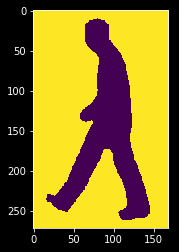

In [17]:
res = p.process('skin-guess/cropped.png')
maskImg = np.array(res.point(ImgThreshold))
plt.imshow(maskImg)
plt.show()


In [18]:
rawImage = Image.open('skin-guess/cropped.png').convert('RGB')
rel = RelevantPixels(rawImage, maskImg)
avg = np.mean(rel, axis=0)
deltas = [diffColor(f, avg) for f in fitz]
print(minIndex(deltas) + 1)


4
